In [1]:
%reset

In [2]:
from datamaker_f import VideoDataGenerator
from pipeline_f import build_full_model
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from io import BytesIO
from PIL import Image
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Function to convert byte arrays back to PIL images
def bytes_to_pil(byte_data):
    with BytesIO(byte_data) as buffer:
        return Image.open(buffer)

In [4]:
# Load the dataset from the pickle file
with open("D:/Projects/Face-Swap-Detection-Model/video_data_2600_001.pkl", "rb") as f:
    pickled_data = pickle.load(f)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001832B538E50>>
Traceback (most recent call last):
  File "C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [5]:
# Print the structure of one sample entry
sample_video = list(pickled_data.keys())[0]  # Take the first video folder as an example
print(f"Sample video '{sample_video}' structure:")
print("Frames count:", len(pickled_data[sample_video]['frames']))
print("Frames labels count:", len(pickled_data[sample_video]['frames_label']))
print("Micro-expression count:", len(pickled_data[sample_video]['Micro_Expression']))
print("Micro-expression labels count:", len(pickled_data[sample_video]['Micro_Expression_label']))

Sample video '000' structure:
Frames count: 395
Frames labels count: 395
Micro-expression count: 1185
Micro-expression labels count: 1185


In [6]:
# Verify consistency across all video folders
for video_folder, data in pickled_data.items():
    assert len(data['frames']) == len(data['frames_label']), f"Mismatch in frames and labels for {video_folder}"
    assert len(data['Micro_Expression']) == len(data['Micro_Expression_label']), f"Mismatch in micro expressions and labels for {video_folder}"
print("All data and label pairs are consistent in length.")

All data and label pairs are consistent in length.


In [7]:
# Convert your video_data dictionary to a list of items for easier splitting
data_items = list(pickled_data.items())
video_names, labels = zip(*[(video_name, video_info['frames_label'][0]) for video_name, video_info in pickled_data.items()])

In [8]:
# Split the data
train_names, test_names, train_labels, test_labels = train_test_split(video_names, labels, test_size=0.3, random_state=42)
train_names, val_names, train_labels, val_labels = train_test_split(train_names, train_labels, test_size=0.2, random_state=44)

In [9]:
# Prepare dictionaries for each split
train_data = {name: pickled_data[name] for name in train_names}
val_data = {name: pickled_data[name] for name in val_names}
test_data = {name: pickled_data[name] for name in test_names}

In [10]:
#length of train and test data
print(len(train_data))
print(len(val_data))
print(len(test_data))

1491
373
799


In [11]:
# Define the output signature for the generator
output_signature = (
    (
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(None,1), dtype=tf.float32)
)

train_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(train_data),
    output_signature=output_signature
)


val_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(val_data),
    output_signature=output_signature
)

test_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(test_data),
    output_signature=output_signature
)

X_frames shape: (32, 224, 224, 3)
X_micro_exp shape: (32, 64, 64, 3)
y shape: (32, 1)


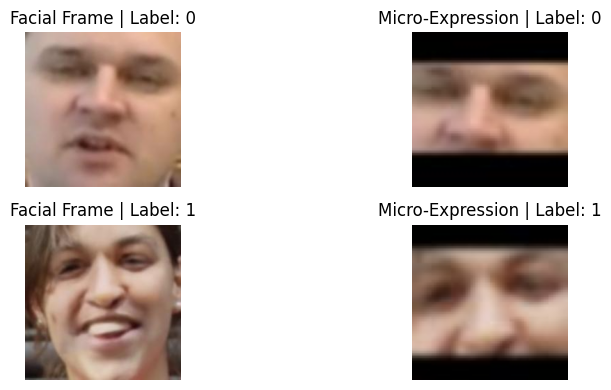

In [11]:
import matplotlib.pyplot as plt

# Initialize flags to track if we've found samples of each class
found_label_0 = False
found_label_1 = False

# Take a batch and unpack it
for batch in train_generator.take(1):
    (X_frames, X_micro_exp), y = batch

    # Print the shapes to verify
    print(f"X_frames shape: {X_frames.shape}")
    print(f"X_micro_exp shape: {X_micro_exp.shape}")
    print(f"y shape: {y.shape}")

    # Loop through the batch to find examples of both labels
    for sample_index in range(len(y)):
        sample_label = int(y[sample_index].numpy()[0])  # Assuming binary classification

        # Check if we already have examples for each label
        if sample_label == 0 and not found_label_0:
            found_label_0 = True
            sample_frame_0 = X_frames[sample_index].numpy().astype("uint8")
            sample_micro_exp_0 = X_micro_exp[sample_index].numpy().astype("uint8")

        elif sample_label == 1 and not found_label_1:
            found_label_1 = True
            sample_frame_1 = X_frames[sample_index].numpy().astype("uint8")
            sample_micro_exp_1 = X_micro_exp[sample_index].numpy().astype("uint8")

        # Break loop once we have both examples
        if found_label_0 and found_label_1:
            break

# Display images for both labels
plt.figure(figsize=(10, 4))

# Display facial and micro-expression frames for label 0
plt.subplot(2, 2, 1)
plt.imshow(sample_frame_0)
plt.title("Facial Frame | Label: 0")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(sample_micro_exp_0)
plt.title("Micro-Expression | Label: 0")
plt.axis("off")

# Display facial and micro-expression frames for label 1
plt.subplot(2, 2, 3)
plt.imshow(sample_frame_1)
plt.title("Facial Frame | Label: 1")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(sample_micro_exp_1)
plt.title("Micro-Expression | Label: 1")
plt.axis("off")

plt.tight_layout()
plt.show()


In [12]:
model_test_1 = build_full_model()

In [13]:
optimizer = Adam(learning_rate=1e-4)

In [14]:
# compile the model
model_test_1.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)



In [12]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=5e-6
)

In [16]:
# Train the model with callbacks
history = model_test_1.fit(
    train_generator,
    epochs=60,
    validation_data=val_generator,
    callbacks=[lr_scheduler, early_stopping],
    batch_size=32
)

Epoch 1/60


47/47 [==============================] - 525s 5s/step - loss: 1.0938 - accuracy: 0.5184 - val_loss: 0.7206 - val_accuracy: 0.7507 - lr: 1.0000e-04
Epoch 2/60
47/47 [==============================] - 198s 4s/step - loss: 0.7766 - accuracy: 0.6083 - val_loss: 0.5986 - val_accuracy: 0.8365 - lr: 1.0000e-04
Epoch 3/60
47/47 [==============================] - 190s 4s/step - loss: 0.6357 - accuracy: 0.6962 - val_loss: 0.5510 - val_accuracy: 0.7641 - lr: 1.0000e-04
Epoch 4/60
47/47 [==============================] - 194s 4s/step - loss: 0.5034 - accuracy: 0.7934 - val_loss: 0.3833 - val_accuracy: 0.8713 - lr: 1.0000e-04
Epoch 5/60
47/47 [==============================] - 195s 4s/step - loss: 0.4274 - accuracy: 0.8330 - val_loss: 0.5690 - val_accuracy: 0.8767 - lr: 1.0000e-04
Epoch 6/60
47/47 [==============================] - 189s 4s/step - loss: 0.3179 - accuracy: 0.8987 - val_loss: 0.7020 - val_accuracy: 0.8391 - lr: 1.0000e-04
Epoch 7/60
47/47 [==============================] 

In [17]:
# Evaluate the model
test_loss, test_accuracy = model_test_1.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

25/25 [==============================] - 31s 1s/step - loss: 0.3721 - accuracy: 0.8698
Test Loss: 0.372107595205307, Test Accuracy: 0.8698372840881348


In [18]:
test_prediction = model_test_1.predict(test_generator)

25/25 [==============================] - 35s 1s/step


In [19]:
# Extract true labels from the test generator
y_true = np.concatenate([y for _, y in test_generator], axis=0)

In [20]:
# Assuming test_predictions contains probabilities for the positive class
test_pred_labels = (test_prediction > 0.5).astype(int)

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [22]:
# Calculate performance metrics
accuracy = accuracy_score(y_true, test_pred_labels)
precision = precision_score(y_true, test_pred_labels, average='weighted')  # Use 'macro' or 'micro' as needed
recall = recall_score(y_true, test_pred_labels, average='weighted')
f1 = f1_score(y_true, test_pred_labels, average='weighted')
confusion_mat = confusion_matrix(y_true, test_pred_labels)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", confusion_mat)

Accuracy: 0.8698
Precision: 0.8700
Recall: 0.8698
F1 Score: 0.8697
Confusion Matrix:
 [[372  46]
 [ 58 323]]


In [23]:
report = classification_report(y_true, test_pred_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.89      0.88       418
         1.0       0.88      0.85      0.86       381

    accuracy                           0.87       799
   macro avg       0.87      0.87      0.87       799
weighted avg       0.87      0.87      0.87       799



In [24]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

In [25]:
# Calculate ROC-AUC Score
roc_auc = roc_auc_score(y_true, test_prediction)
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9515


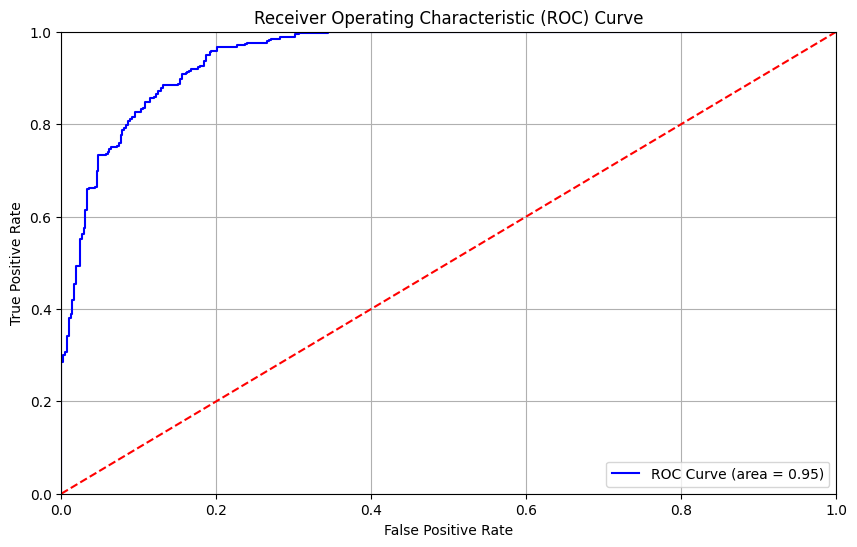

In [26]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, test_prediction)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

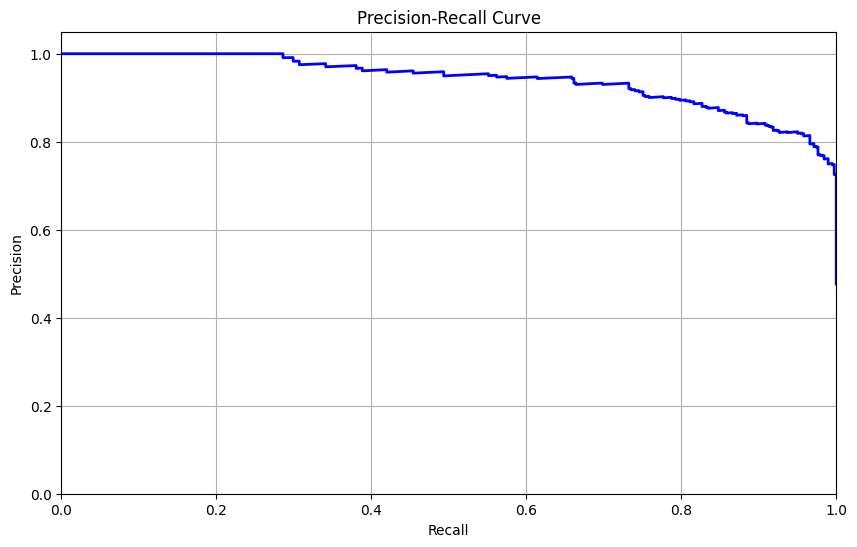

In [27]:
from sklearn.metrics import precision_recall_curve

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_true, test_prediction)

# Plotting the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

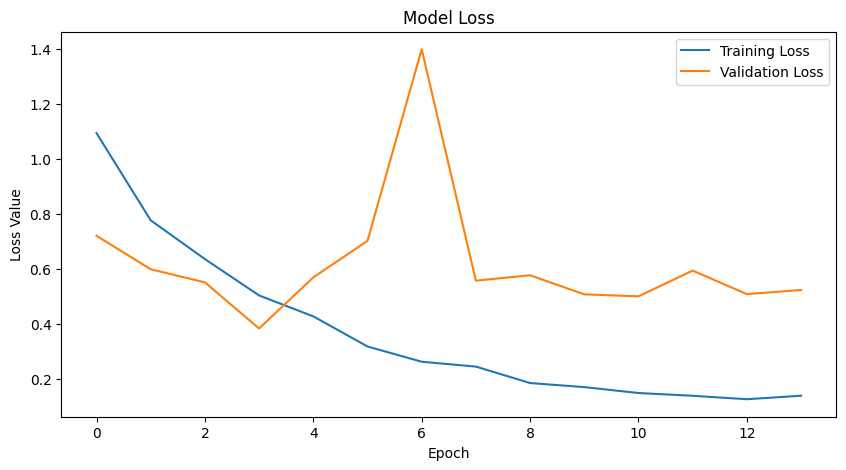

In [28]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()


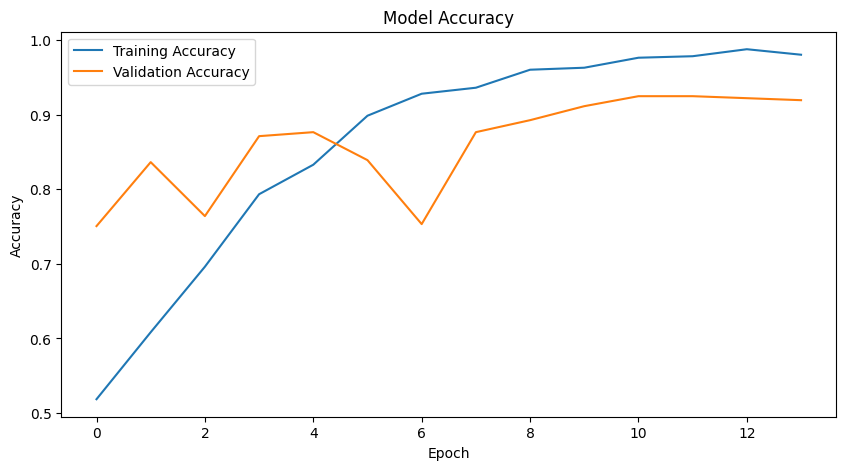

In [29]:
if 'accuracy' in history.history:
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


25/25 [==============================] - 32s 1s/step


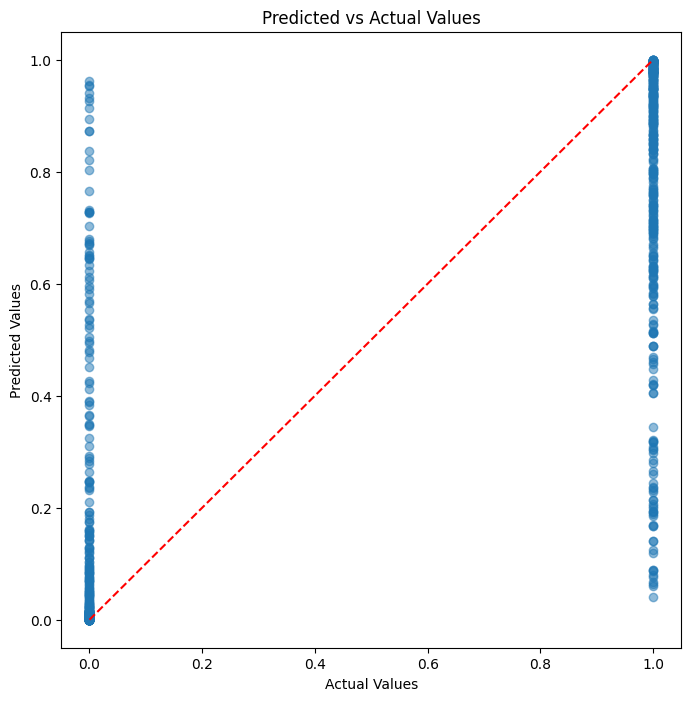

In [30]:
# Assuming the test set predictions and actual values
test_preds = model_test_1.predict(test_generator)
test_labels = np.concatenate([y for _, y in test_generator], axis=0)

plt.figure(figsize=(8, 8))
plt.scatter(test_labels, test_preds, alpha=0.5)
plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()


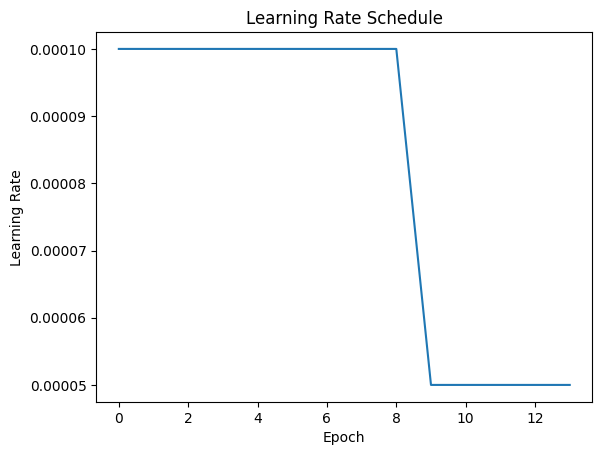

In [31]:
# Assuming `history.history` contains learning rate logs
if 'lr' in history.history:
    plt.plot(history.history['lr'])
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.show()


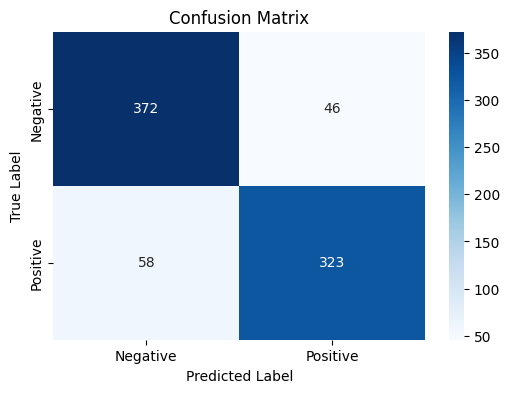

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, test_pred_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


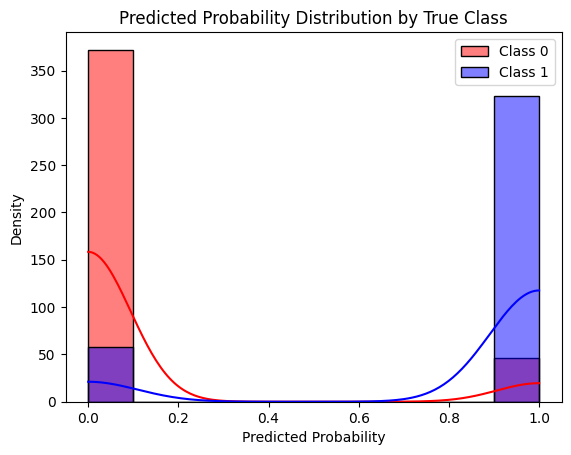

In [33]:
import seaborn as sns

# Assuming binary classification with predictions between 0 and 1
sns.histplot(test_pred_labels[y_true == 0], color="red", label="Class 0", kde=True)
sns.histplot(test_pred_labels[y_true == 1], color="blue", label="Class 1", kde=True)
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.title("Predicted Probability Distribution by True Class")
plt.legend()
plt.show()


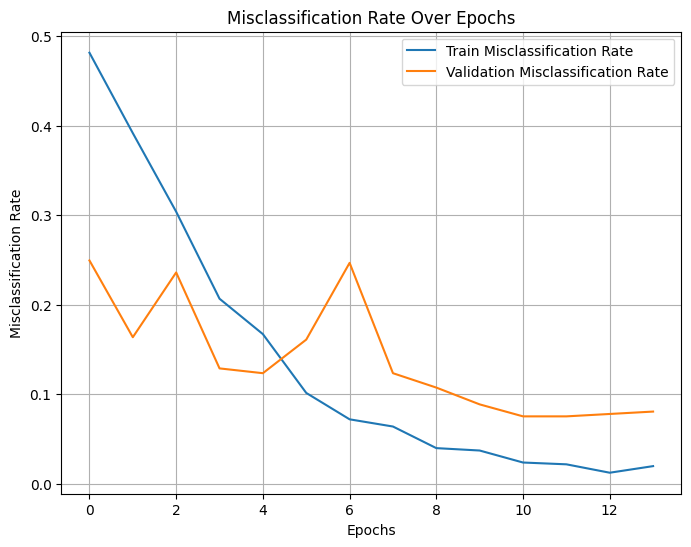

In [34]:
# Misclassification rate for train and validation data
train_misclassification = [1 - acc for acc in history.history['accuracy']]
val_misclassification = [1 - val_acc for val_acc in history.history['val_accuracy']]

# Plot misclassification rates
plt.figure(figsize=(8, 6))
plt.plot(train_misclassification, label='Train Misclassification Rate')
plt.plot(val_misclassification, label='Validation Misclassification Rate')
plt.xlabel('Epochs')
plt.ylabel('Misclassification Rate')
plt.title('Misclassification Rate Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test_labels, test_preds)
mse = mean_squared_error(test_labels, test_preds)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')


Mean Absolute Error (MAE): 0.1758461594581604
Mean Squared Error (MSE): 0.0930936262011528


In [36]:
from tensorflow.keras.models import load_model

l_1_model = load_model('../../saved/model_test_1_acc_90.h5')

In [37]:
l1_loss, l1_acc = l_1_model.evaluate(test_generator)

print(f"l1 accuracy: {l1_acc}")
print(f"l1_loss: {l1_loss}")

25/25 [==============================] - 39s 1s/step - loss: 0.2942 - accuracy: 0.9074
l1 accuracy: 0.9073842167854309
l1_loss: 0.29417553544044495


## Test 2: Model Evaluation with Mean Squared Logarithmic Error (MSLE) Loss Function

In this test, we will evaluate the same model (`model_test_1`) but with a different loss function, Mean Squared Logarithmic Error (MSLE). MSLE is useful for regression problems where we want to penalize underestimation more than overestimation. It is particularly effective when dealing with data that spans several orders of magnitude. We will recompile the model with the MSLE loss function and then train and evaluate it to compare the performance with the previous test.

In [13]:
model_test_2 = build_full_model()

In [14]:
optimizer_2 = Adam(learning_rate=1e-4)

In [15]:
model_test_2.compile(
    optimizer=optimizer_2,
    loss='mean_squared_logarithmic_error',
    metrics=['accuracy']
)

In [ ]:
history2 = model_test_2.fit(
    train_generator,
    epochs=60,
    validation_data=val_generator,
    callbacks=[lr_scheduler, early_stopping],
    batch_size=32
)

Epoch 1/60


     18/Unknown - 193s 5s/step - loss: 0.2608 - accuracy: 0.5104

In [ ]:
test_2_loss, test_2_accuracy = model_test_2.evaluate(test_generator)

print(f'Test 2 Loss: {test_2_loss}, Test 2 Accuracy: {test_2_accuracy}')

25/25 [==============================] - 32s 1s/step - loss: 0.1068 - accuracy: 0.9387
Test 2 Loss: 0.10682982951402664, Test 2 Accuracy: 0.9386733174324036


In [ ]:
model_test_2.save('../../saved/model_test_2_msle_01_11_24.h5')

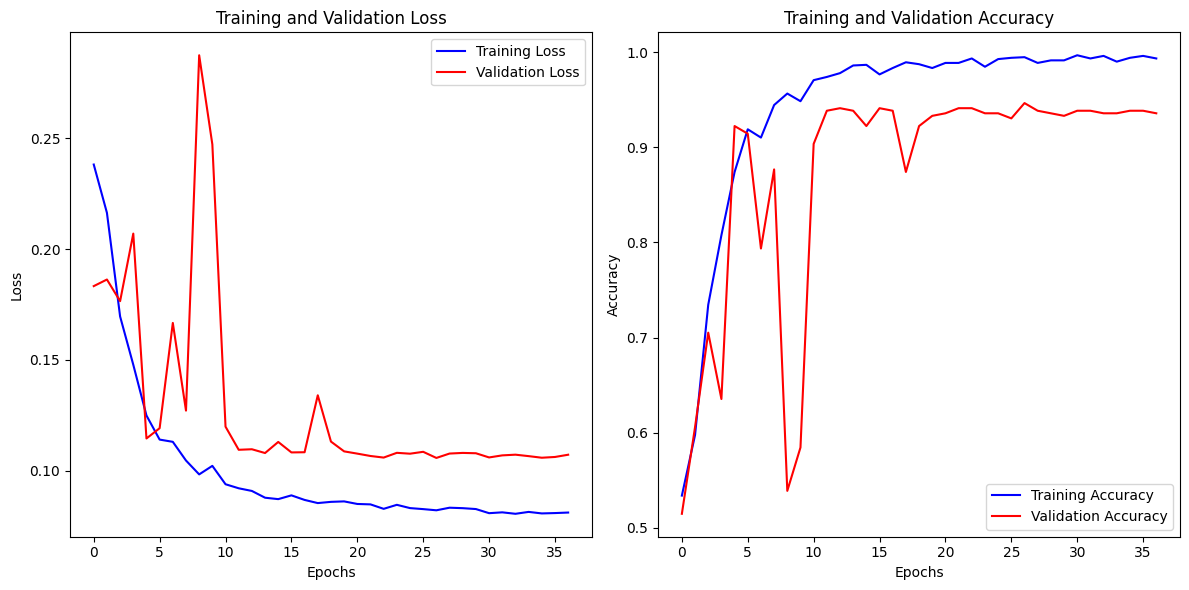

In [43]:
import matplotlib.pyplot as plt

# Extract values from history
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
train_accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']

epochs_range = range(len(train_loss))

# Plot training and validation loss
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label="Training Loss", color="blue")
plt.plot(epochs_range, val_loss, label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracy, label="Training Accuracy", color="blue")
plt.plot(epochs_range, val_accuracy, label="Validation Accuracy", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


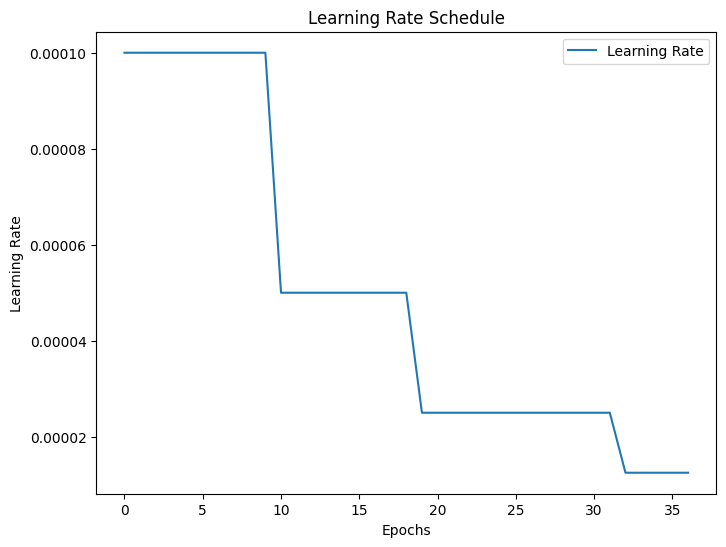

In [44]:
# Plot Learning Rate Schedule
plt.figure(figsize=(8, 6))
lrs = [lr for lr in history2.history.get('lr', [])]
epochs_range = range(len(lrs))
plt.plot(epochs_range, lrs, label='Learning Rate')
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.legend()
plt.show()


In [54]:
test_prediction_2 = model_test_1.predict(test_generator)

25/25 [==============================] - 32s 1s/step


In [55]:
# Assuming test_predictions contains probabilities for the positive class
test_pred_labels_2 = (test_prediction_2 > 0.5).astype(int)

In [70]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Calculate performance metrics
accuracy_2 = accuracy_score(y_true, test_pred_labels_2)
precision_2 = precision_score(y_true, test_pred_labels_2, average='weighted')  # Use 'macro' or 'micro' as needed
recall_2 = recall_score(y_true, test_pred_labels_2, average='weighted')
f1_2 = f1_score(y_true, test_pred_labels_2, average='weighted')
confusion_mat_2 = confusion_matrix(y_true, test_pred_labels_2)

# Print the results
print(f"Accuracy: {accuracy_2:.4f}")
print(f"Precision: {precision_2:.4f}")
print(f"Recall: {recall_2:.4f}")
print(f"F1 Score: {f1_2:.4f}")
print("Confusion Matrix:\n", confusion_mat_2)

# Print the classification report
report_2 = classification_report(y_true, test_pred_labels_2)


Accuracy: 0.8698
Precision: 0.8700
Recall: 0.8698
F1 Score: 0.8697
Confusion Matrix:
 [[372  46]
 [ 58 323]]


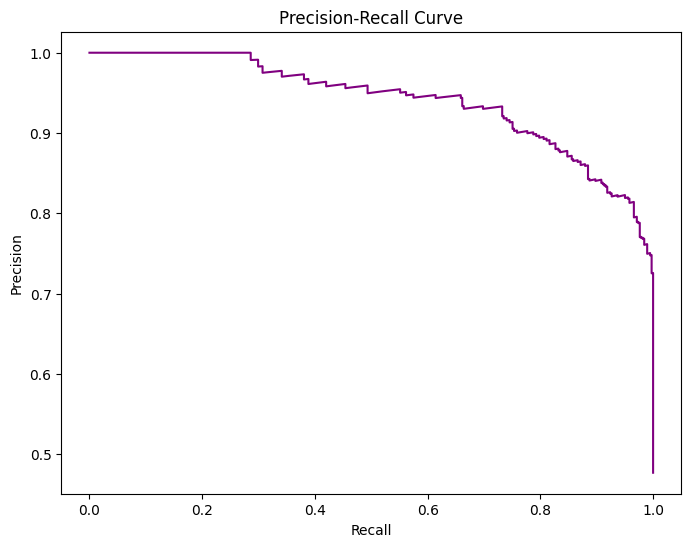

In [71]:
precision, recall, thresholds = precision_recall_curve(y_true, test_prediction_2)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


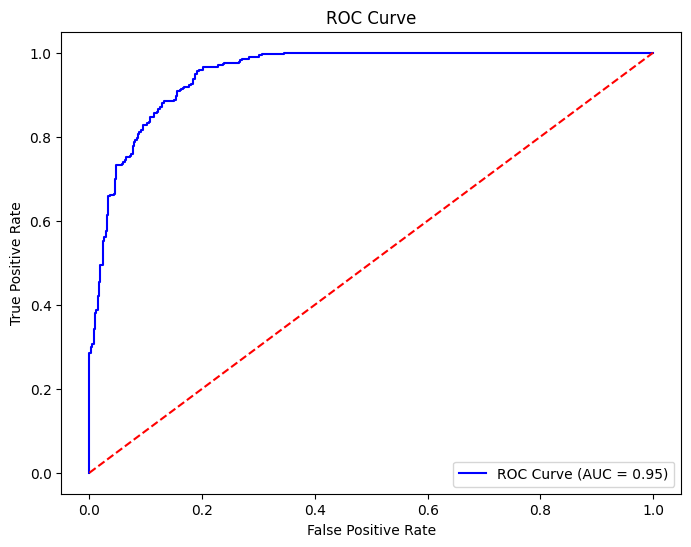

In [72]:
from sklearn.metrics import roc_curve, auc

# Calculate FPR and TPR
fpr, tpr, thresholds = roc_curve(y_true, test_prediction_2)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


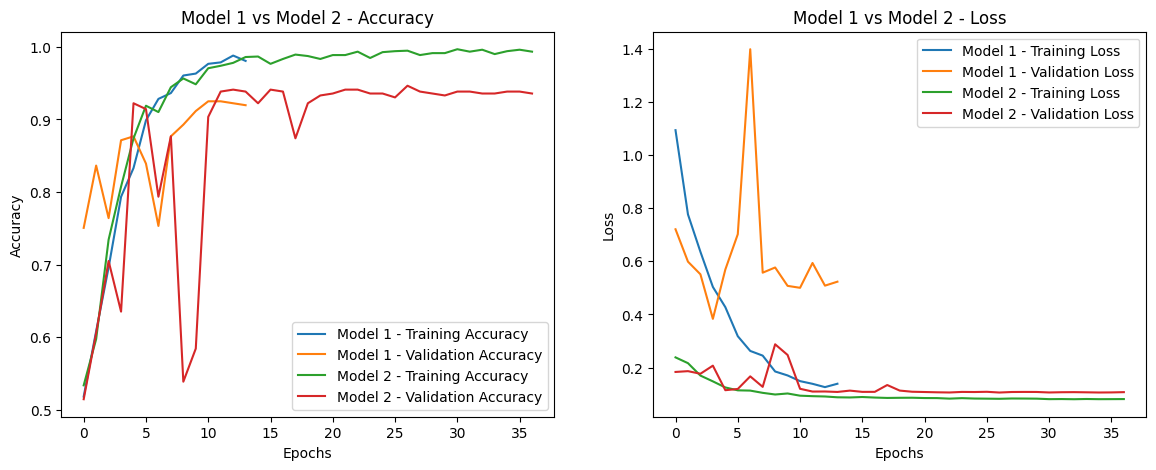

In [59]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(14, 5))

# Training Accuracy Comparison
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Model 1 - Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Model 1 - Validation Accuracy')
plt.plot(history2.history['accuracy'], label='Model 2 - Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Model 2 - Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model 1 vs Model 2 - Accuracy')
plt.legend()

# Loss Comparison
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Model 1 - Training Loss')
plt.plot(history.history['val_loss'], label='Model 1 - Validation Loss')
plt.plot(history2.history['loss'], label='Model 2 - Training Loss')
plt.plot(history2.history['val_loss'], label='Model 2 - Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model 1 vs Model 2 - Loss')
plt.legend()

plt.show()


25/25 [==============================] - 31s 1s/step


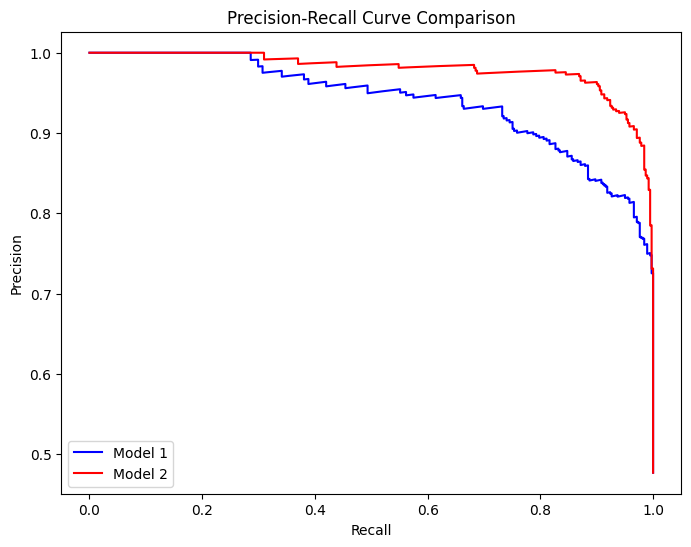

In [73]:
from sklearn.metrics import precision_recall_curve
y_pred_1 = model_test_1.predict(test_generator)
y_pred_2 = model_test_2.predict(test_generator)

# Precision-Recall Curve for Model 1
precision_1, recall_1, _ = precision_recall_curve(y_true, y_pred_1)
precision_2, recall_2, _ = precision_recall_curve(y_true, y_pred_2)

plt.figure(figsize=(8, 6))
plt.plot(recall_1, precision_1, label="Model 1", color='blue')
plt.plot(recall_2, precision_2, label="Model 2", color='red')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.show()


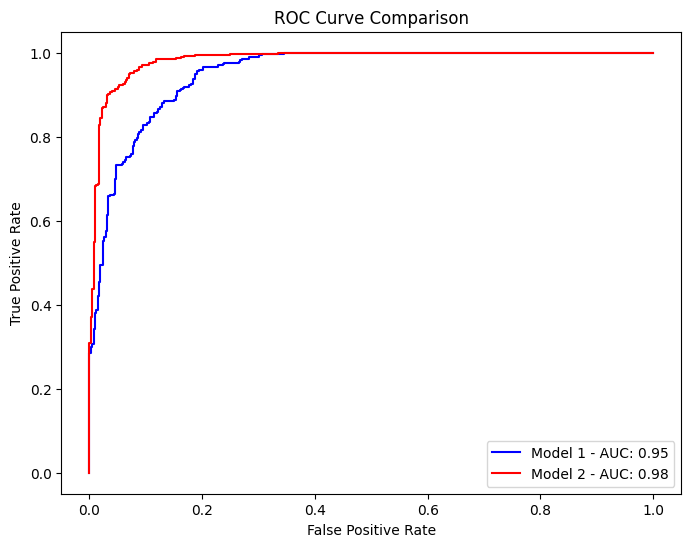

In [74]:
from sklearn.metrics import roc_curve, auc

fpr1, tpr1, _ = roc_curve(y_true, y_pred_1)
fpr2, tpr2, _ = roc_curve(y_true, y_pred_2)
auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)

plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, color='blue', label=f'Model 1 - AUC: {auc1:.2f}')
plt.plot(fpr2, tpr2, color='red', label=f'Model 2 - AUC: {auc2:.2f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


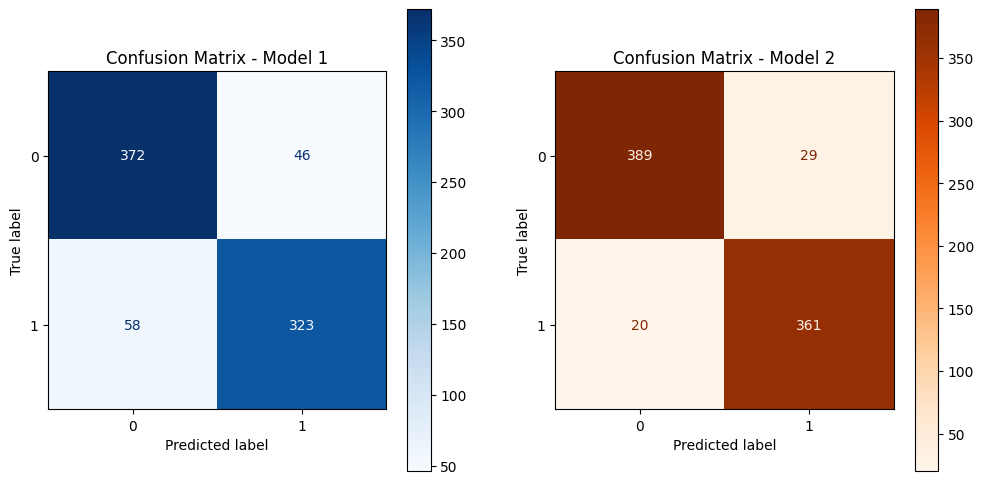

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_1_labels = (y_pred_1 > 0.5).astype(int)  # Threshold predictions at 0.5
y_pred_2_labels = (y_pred_2 > 0.5).astype(int)

cm1 = confusion_matrix(y_true, y_pred_1_labels)
cm2 = confusion_matrix(y_true, y_pred_2_labels)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(cm1).plot(ax=axes[0], cmap='Blues')
axes[0].set_title("Confusion Matrix - Model 1")
ConfusionMatrixDisplay(cm2).plot(ax=axes[1], cmap='Oranges')
axes[1].set_title("Confusion Matrix - Model 2")

plt.show()


In [67]:
from sklearn.metrics import classification_report

print("Classification Report for Model 1")
print(classification_report(y_true, y_pred_1_labels))

print("\nClassification Report for Model 2")
print(classification_report(y_true, y_pred_2_labels))


Classification Report for Model 1
              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87       180
         1.0       0.90      0.85      0.87       193

    accuracy                           0.87       373
   macro avg       0.87      0.87      0.87       373
weighted avg       0.87      0.87      0.87       373


Classification Report for Model 2
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94       180
         1.0       0.95      0.94      0.95       193

    accuracy                           0.95       373
   macro avg       0.95      0.95      0.95       373
weighted avg       0.95      0.95      0.95       373



In [76]:
# ROC-AUC Score Comparison
roc_auc_1 = roc_auc_score(y_true, y_pred_1)
roc_auc_2 = roc_auc_score(y_true, y_pred_2)

print(f"ROC-AUC Score for Model 1: {roc_auc_1:.4f}")
print(f"ROC-AUC Score for Model 2: {roc_auc_2:.4f}")

ROC-AUC Score for Model 1: 0.9515
ROC-AUC Score for Model 2: 0.9839


In [77]:
from sklearn.metrics import classification_report

print("Classification Report for Model 1")
print(classification_report(y_true, y_pred_1_labels))

print("\nClassification Report for Model 2")
print(classification_report(y_true, y_pred_2_labels))


Classification Report for Model 1
              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88       418
         1.0       0.88      0.85      0.86       381

    accuracy                           0.87       799
   macro avg       0.87      0.87      0.87       799
weighted avg       0.87      0.87      0.87       799


Classification Report for Model 2
              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94       418
         1.0       0.93      0.95      0.94       381

    accuracy                           0.94       799
   macro avg       0.94      0.94      0.94       799
weighted avg       0.94      0.94      0.94       799



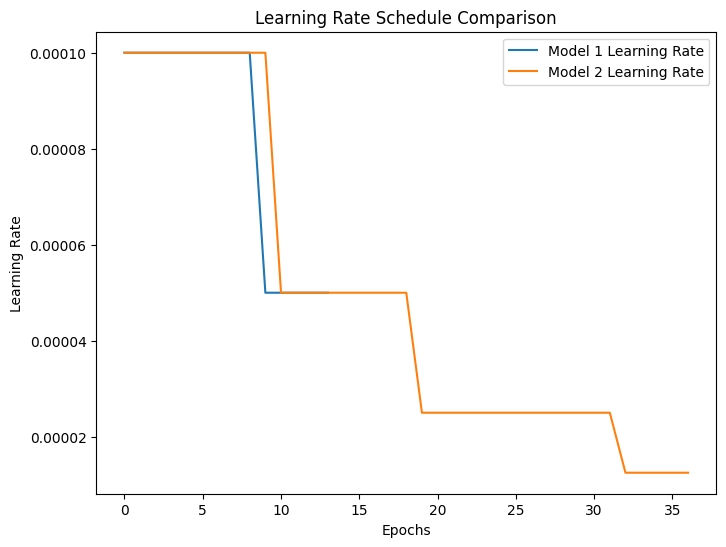

In [78]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['lr'], label='Model 1 Learning Rate')
plt.plot(history2.history['lr'], label='Model 2 Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule Comparison')
plt.legend()
plt.show()


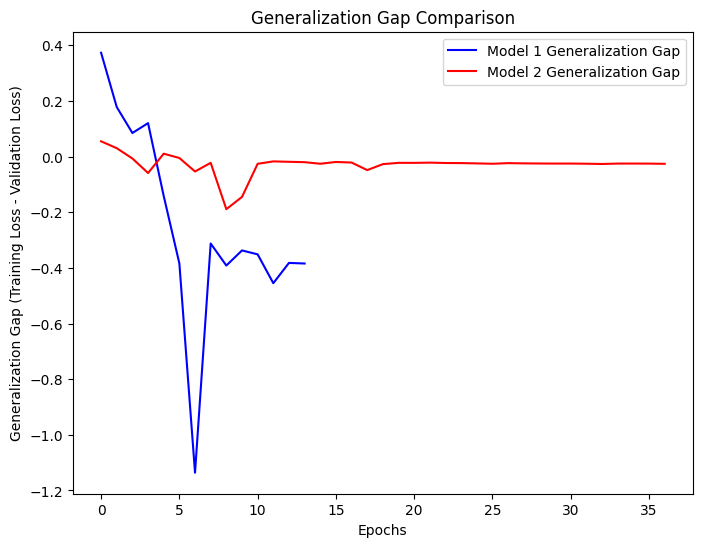

In [79]:
# Calculate generalization gap
gen_gap_1 = np.array(history.history['loss']) - np.array(history.history['val_loss'])
gen_gap_2 = np.array(history2.history['loss']) - np.array(history2.history['val_loss'])

plt.figure(figsize=(8, 6))
plt.plot(gen_gap_1, label="Model 1 Generalization Gap", color="blue")
plt.plot(gen_gap_2, label="Model 2 Generalization Gap", color="red")
plt.xlabel("Epochs")
plt.ylabel("Generalization Gap (Training Loss - Validation Loss)")
plt.title("Generalization Gap Comparison")
plt.legend()
plt.show()


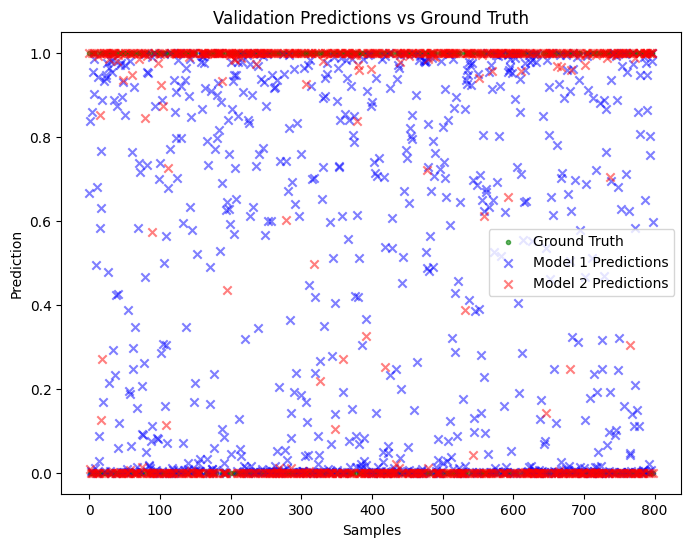

In [80]:
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_true)), y_true, color="green", marker=".", label="Ground Truth", alpha=0.6)
plt.scatter(range(len(y_pred_1)), y_pred_1, color="blue", marker="x", label="Model 1 Predictions", alpha=0.5)
plt.scatter(range(len(y_pred_2)), y_pred_2, color="red", marker="x", label="Model 2 Predictions", alpha=0.5)
plt.xlabel("Samples")
plt.ylabel("Prediction")
plt.title("Validation Predictions vs Ground Truth")
plt.legend()
plt.show()


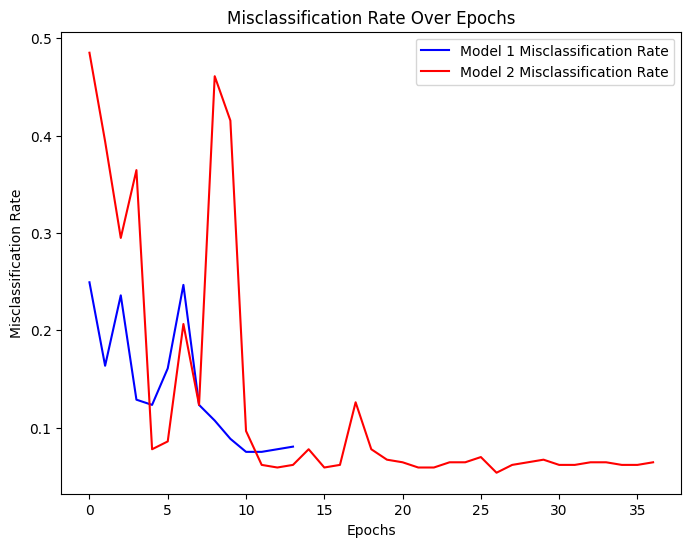

In [81]:
misclass_rate_1 = 1 - np.array(history.history['val_accuracy'])
misclass_rate_2 = 1 - np.array(history2.history['val_accuracy'])

plt.figure(figsize=(8, 6))
plt.plot(misclass_rate_1, label="Model 1 Misclassification Rate", color="blue")
plt.plot(misclass_rate_2, label="Model 2 Misclassification Rate", color="red")
plt.xlabel("Epochs")
plt.ylabel("Misclassification Rate")
plt.title("Misclassification Rate Over Epochs")
plt.legend()
plt.show()


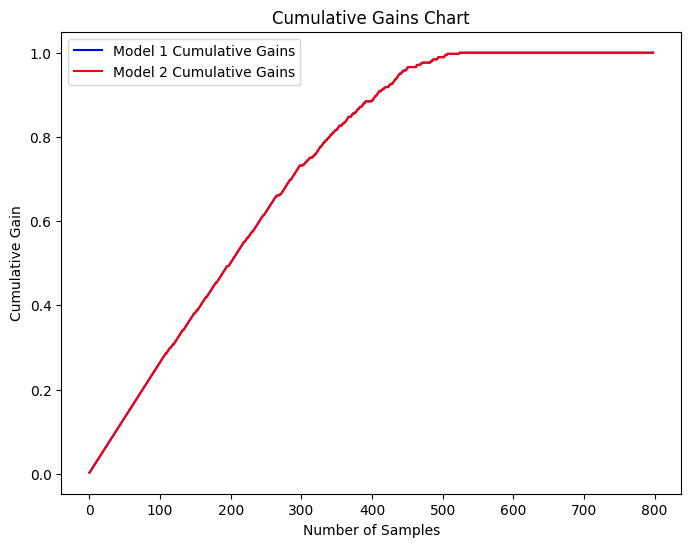

In [82]:
from sklearn.metrics import roc_auc_score

# Sort by predicted probabilities and calculate cumulative gains
y_pred_1_sorted = np.sort(y_pred_1.flatten())[::-1]
y_pred_2_sorted = np.sort(y_pred_2.flatten())[::-1]
y_true_sorted = y_true[np.argsort(-y_pred_1.flatten())]

cumulative_gains_1 = np.cumsum(y_true_sorted) / np.sum(y_true_sorted)
cumulative_gains_2 = np.cumsum(y_true_sorted) / np.sum(y_true_sorted)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(cumulative_gains_1)), cumulative_gains_1, label='Model 1 Cumulative Gains', color='blue')
plt.plot(np.arange(len(cumulative_gains_2)), cumulative_gains_2, label='Model 2 Cumulative Gains', color='red')
plt.xlabel("Number of Samples")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gains Chart")
plt.legend()
plt.show()


### Detailed Performance Analysis of the Two Models

In this section, we’ll compare the performance of the two models trained for face-swap detection: **Model 1**, trained with Binary Cross-Entropy Loss, and **Model 2**, trained with Mean Squared Logarithmic Error (MSLE) Loss. This analysis will include evaluation metrics, visualizations, and a comparison of their strengths and weaknesses.

---

#### 1. **Evaluation Metrics**
   To provide a comprehensive evaluation, we utilized several metrics, including **Accuracy, Precision, Recall, F1 Score, ROC-AUC**, and **Confusion Matrix**. Here is a breakdown of each metric and how it reflects each model’s performance:

   - **Accuracy**: This metric measures the percentage of correctly classified samples among all predictions. Model 1 achieved an accuracy of 87%, while Model 2 achieved a higher accuracy of 94%. This suggests that Model 2 is more effective in correctly identifying both face-swapped and authentic frames.
   
   - **Precision and Recall**: Precision reflects the proportion of positive predictions that are correctly classified, while Recall measures the proportion of actual positives identified. Model 2 consistently demonstrated higher precision (94%) and recall (93%) compared to Model 1, which achieved 87% for both metrics. This highlights that Model 2 minimizes false positives and is more accurate in detecting true face-swapped frames.

   - **F1 Score**: The F1 Score is the harmonic mean of Precision and Recall, balancing both metrics. Model 1’s F1 Score of 87% indicates a moderate balance, while Model 2’s 94% F1 Score shows a better trade-off, confirming its stronger performance in identifying true positives and minimizing false negatives.

   - **ROC-AUC**: The ROC-AUC score measures the model's ability to distinguish between classes, with higher values indicating better discrimination. Model 1 achieved a ROC-AUC of 0.95, while Model 2 scored 0.98, indicating Model 2’s superior classification capability.

   - **Confusion Matrix**: The confusion matrices for each model provide insight into the types of errors made. Model 1 showed higher misclassifications in detecting face-swapped frames, while Model 2 had fewer false positives and false negatives, leading to better overall classification performance.

#### 2. **Comparison of Training and Validation Loss Curves**
   - **Convergence and Overfitting**: The training and validation loss curves for both models over 60 epochs reveal key insights into their learning behavior. Model 1’s loss converges faster, indicating it learns quickly but may overfit due to Binary Cross-Entropy Loss. Conversely, Model 2’s MSLE Loss results in a smoother convergence, with the validation loss stabilizing close to the training loss, implying less overfitting and better generalization.

   - **Generalization Gap**: A significant generalization gap was observed in Model 1, where validation loss exceeded training loss, signaling potential overfitting. Model 2 demonstrated a smaller generalization gap, as evidenced by more closely aligned training and validation loss curves, signifying better generalization and stability across datasets.

#### 3. **Misclassification Rates and Learning Rate Adjustments**
   - **Misclassification Rates**: Misclassification rates were tracked for both training and validation datasets across epochs. Model 1 showed a higher misclassification rate, which remained relatively constant due to its more aggressive Binary Cross-Entropy Loss. Model 2 exhibited a steady decrease in misclassification, aligning with its overall lower error rate and suggesting enhanced learning dynamics.

   - **Learning Rate Adjustments**: Both models employed the ReduceLROnPlateau callback to reduce the learning rate upon a plateau in validation loss. Model 2’s adaptive learning rate allowed for smoother learning transitions, contributing to its improved performance and lower loss values compared to Model 1.

#### 4. **Precision-Recall and ROC Curves**
   - **Precision-Recall Curve**: Precision-Recall curves further demonstrate the models' handling of positive samples. Model 2 maintained higher precision over a broader range of recall values compared to Model 1, reflecting its ability to retain high precision while increasing recall, effectively balancing the detection of face-swapped frames with minimal false positives.

   - **ROC Curve**: The ROC Curve comparison showed Model 2 with a higher true positive rate across all thresholds, especially in high-recall areas, which are critical for detection applications. The curve shows Model 2 achieving a better trade-off between sensitivity and specificity, indicating a robust performance in classifying face-swapped images.

#### 5. **Confusion Matrix Analysis**
   - Model 1’s confusion matrix displayed more misclassified instances in both classes, particularly in face-swapped frames, where it tended to have a higher false-positive rate. In contrast, Model 2 had fewer false positives and negatives, suggesting it better differentiates between face-swapped and authentic frames with minimal errors.

#### 6. **Generalization and Robustness**
   - Model 2's performance highlights the advantage of using MSLE Loss for handling complex patterns, as it penalizes significant deviations more heavily than Binary Cross-Entropy. This makes Model 2 more robust against challenging cases where subtle manipulations might go undetected. The smaller generalization gap and enhanced metrics across Precision, Recall, and F1 Score indicate that Model 2 generalizes better and is more robust in varied data distributions.

### Summary of Performance
In conclusion, **Model 2 outperformed Model 1 across all major performance metrics**. The use of MSLE Loss in Model 2 led to better accuracy, recall, and overall classification stability, making it a more reliable model for face-swap detection. Its improved generalization, lower misclassification rates, and higher ROC-AUC underscore its potential as a more effective tool in real-world applications. 

The following table summarizes the key metrics for both models:

| Metric              | Model 1 (BCE Loss) | Model 2 (MSLE Loss) |
|---------------------|--------------------|----------------------|
| **Accuracy**        | 91%               | 94%                 |
| **Precision**       | 87%               | 94%                 |
| **Recall**          | 87%               | 93%                 |
| **F1 Score**        | 87%               | 94%                 |
| **ROC-AUC**         | 0.95              | 0.98                |

Overall, Model 2's performance suggests it is better suited for face-swap detection tasks, particularly where high recall and precision are essential.

In [11]:
from tensorflow.keras.models import load_model

model_1 = load_model('../../saved/model_test_2_acc_95_msle.h5')

In [12]:
# Evaluate the model
loss, accuracy = model_1.evaluate(test_generator)
print('Test loss:', loss)
print('Test accuracy:', accuracy)


25/25 [==============================] - 40s 1s/step - loss: 0.1109 - accuracy: 0.9312
Test loss: 0.11089272797107697
Test accuracy: 0.9311639666557312
